# Dataset handling tutorial

The GrIML package is used for the production of the Greenland ice-marginal lake inventory series, which is freely available through the [GEUS Dataverse](https://doi.org/10.22008/FK2/MBKW9N). This dataset is a series of annual inventories, mapping the extent and presence of lakes across Greenland that share a margin with the Greenland Ice Sheet and/or the surrounding ice caps and periphery glaciers. 

Here, we will look at how to load and handle the dataset, and provide details on its contents.

First let's load the packages that we will use in this tutorial.

In [28]:
# Import all relevant packages for this tutorial
import wget
import geopandas as gpd
import glob
import numpy as np
import matplotlib.pyplot as plt

## Getting started

The GrIML ice-marginal lake inventory series dataset is available on the [GEUS Dataverse](https://doi.org/10.22008/FK2/MBKW9N), which can be downloaded using wget.

In [29]:
# Define GEUS Dataverse urls to download ice-marginal lake dataset
urls = ["https://dataverse.geus.dk/api/access/datafile/88448",
        "https://dataverse.geus.dk/api/access/datafile/88440",
        "https://dataverse.geus.dk/api/access/datafile/88442",
        "https://dataverse.geus.dk/api/access/datafile/88447",
        "https://dataverse.geus.dk/api/access/datafile/88446",
        "https://dataverse.geus.dk/api/access/datafile/88443",
        "https://dataverse.geus.dk/api/access/datafile/88445",
        "https://dataverse.geus.dk/api/access/datafile/88449",
        ]

# Download files
for u in urls:
    filename = wget.download(u)

One of the inventories in the dataset series can be opened and plotted in Python using geopandas. In this example, let's take the 2023 inventory (version 2).

<Axes: >

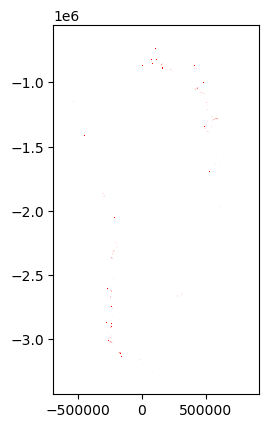

In [30]:
# Open the 2023 inventory
iml = gpd.read_file("20230101-ESA-GRIML-IML-fv2.gpkg")

# Simple plot
iml.plot(color="red")

Plotting all shapes can be difficult to see without zooming around and exploring the plot. We can dissolve all common lakes and then plot the centroid points of these to get a better overview.

<Axes: >

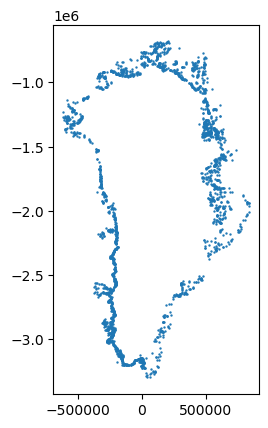

In [31]:
# Dissolve inventory classifications by identification number
iml_d = iml.dissolve(by="lake_id")

# Get centroid point for each lake
iml_d["centroid"] = iml_d.geometry.centroid

# Plot lakes as points
iml_d["centroid"].plot(markersize=0.5)

## Generating statistics

We can extract basic statistics from an ice-marginal lake inventory in the dataset series using simple querying. Let's take the 2022 inventory (version 2) in this example and first determine the number of classified lakes, and then the number of unique lakes.

In [32]:
# Load the 2022 inventory
iml = gpd.read_file("20220101-ESA-GRIML-IML-fv2.gpkg")

# Dissolve by lake id to get all unique lakes as dissolved polygons
iml_d = iml.dissolve(by='lake_id')

# Print counts
print("Total number of detected lakes: " + str(len(iml)))
print("Total number of unique lakes: " + str(len(iml_d)))

Total number of detected lakes: 3561
Total number of unique lakes: 2550


We can count the number of classifications from each method, where `SAR` denotes classifications from SAR backscatter classification, `VIS` denotes classifications from multi-spectral indices, and `DEM` denotes classifications using sink detection.

In [33]:
# Count lakes by classifications
print(iml['method'].value_counts())

method
DEM    2603
SAR     841
VIS     117
Name: count, dtype: int64


Let's say we would like to count the number of ice-marginal lakes that share a margin with the Greenland Ice Sheet and broken down by region. We can do this by first extracting all lakes classified by a common margin with the ice sheet (`ICE_SHEET`) and then count all lakes per region.

In [34]:
# Filter to lakes with an ice sheet margin
iml_d_ice_sheet = iml_d[iml_d['margin'] == 'ICE_SHEET']

# Count lakes by region
print(iml_d_ice_sheet['region'].value_counts())

region
SW    576
NE    448
NO    223
NW    187
CW    141
CE    133
SE    119
Name: count, dtype: int64


We can also determine the average, minimum and maximum lake size per region.

In [35]:
# Calculate surface area of all unique lakes (dissolved)
iml_d['area_sqkm'] = iml_d.geometry.area/10**6

# Group lakes by region and determine average, min, max
print(iml_d.groupby(['region'])['area_sqkm'].mean())
print(iml_d.groupby(['region'])['area_sqkm'].min())
print(iml_d.groupby(['region'])['area_sqkm'].max())

region
CE    0.442842
CW    0.718431
NE    0.938450
NO    0.434287
NW    0.526338
SE    0.500289
SW    0.680217
Name: area_sqkm, dtype: float64
region
CE    0.0502
CW    0.0504
NE    0.0505
NO    0.0500
NW    0.0501
SE    0.0502
SW    0.0502
Name: area_sqkm, dtype: float64
region
CE      9.1090
CW     35.8692
NE    106.4783
NO      6.3879
NW     15.0309
SE     10.9583
SW     31.2105
Name: area_sqkm, dtype: float64


## Cross inventory comparison

All inventories in the ice-marginal lake inventory series can be treated as time-series to look at change in lake abundance and size over time. Let's take an example where we will generate a time-series of lake abundance change at the margins of Greenland's periphery ice caps and glaciers. First we load all inventories as a series of GeoDataFrames.

In [36]:
# Get list of all inventory series files
in_dir = '*IML-fv2.gpkg'

# Iterate through inventories
gdfs=[]
for f in list(sorted(glob.glob(in_dir))):

    # Load inventory and dissolve by unique identifications
    gdf = gpd.read_file(f)
    gdf = gdf.loc[gdf.geometry.is_valid]
    gdf = gdf.dissolve(by='lake_id')

    # Update geometry area information
    gdf['area_sqkm'] = gdf.geometry.area/10**6

    # Append to list
    gdfs.append(gdf)

Then we count lakes with a shared ice cap/glacier margin from each inventory, splitting counts by region.

In [37]:
# Create empty lists for region counts
b=['NW', 'NO', 'NE', 'CE', 'SE', 'SW', 'CW']
ic_nw=[]
ic_no=[]
ic_ne=[]
ic_ce=[]
ic_se=[]
ic_sw=[]
ic_cw=[]
ice_cap_abun = [ic_nw, ic_no, ic_ne, ic_ce, ic_se, ic_sw, ic_cw]

# Iterate through geodataframes
for g in gdfs:

    # Filter by margin type
    icecap = g[g['margin'] == 'ICE_CAP']

    # Append regional lake counts
    for i in range(len(b)):
        ice_cap_abun[i].append(icecap['region'].value_counts()[b[i]])

We can then plot all of our lake counts as a stacked bar plot.

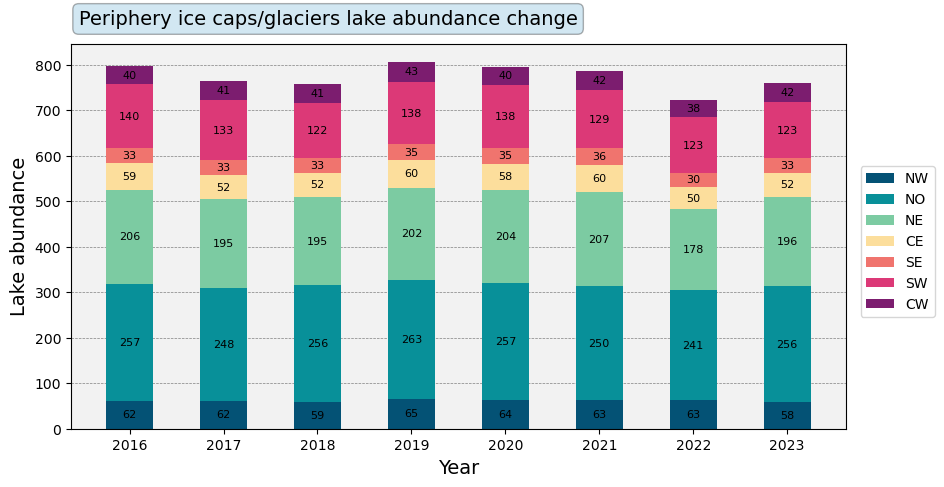

In [38]:
# Define plotting attributes
years=list(range(2016,2024,1))
col=['#045275', '#089099', '#7CCBA2', '#FCDE9C', '#F0746E', '#DC3977', '#7C1D6F']
bottom=np.zeros(8)

# Prime plotting area
fig, ax = plt.subplots(1, figsize=(10,5))

# Plot lake counts as stacked bar plots
for i in range(len(ice_cap_abun)):
    p = ax.bar(years, ice_cap_abun[i], 0.5, color=col[i], label=b[i], bottom=bottom)
    bottom += ice_cap_abun[i]
    ax.bar_label(p, label_type='center', fontsize=8)

# Add legend
ax.legend(bbox_to_anchor=(1.01,0.7))

# Change plotting aesthetics
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', linewidth=0.5)
ax.set_facecolor("#f2f2f2")

# Add title
props = dict(boxstyle='round', facecolor='#6CB0D6', alpha=0.3)
ax.text(0.01, 1.05, 'Periphery ice caps/glaciers lake abundance change',
         fontsize=14, horizontalalignment='left', bbox=props, transform=ax.transAxes)

# Add axis labels
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Lake abundance', fontsize=14)

# Show plot
plt.show()